# Semi-supervised Learning


Lo primero que haremos será cargar todas las librerías que necesitamos

In [ ]:
import numpy as np
import math
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_wine
from sklearn.metrics import pairwise_distances
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, RobustScaler,StandardScaler
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Fijamos la semilla aleatoria para numpy
np.random.seed(42)

## Segmentación por colores de imagen médica

Lo primero que haremos será cargar la imagen que en nuestro caso es una imagen de células sanguíneas. Donde hay globulos rojos, blancos y plasma.

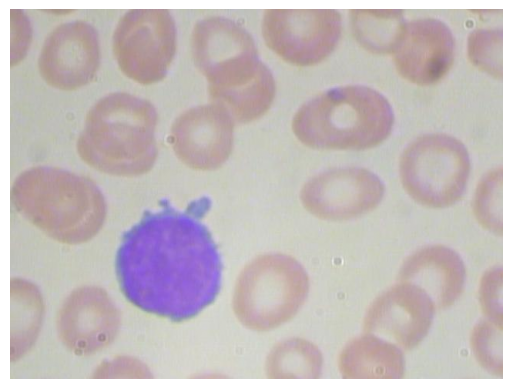

In [ ]:

url = "https://raw.githubusercontent.com/Shenggan/BCCD_Dataset/master/BCCD/JPEGImages/BloodImage_00356.jpg"

# Descargamos la imagen
response = requests.get(url)
response.raise_for_status()

# La abrimos con Image de PIL
medical_png = Image.open(BytesIO(response.content))

# La pasamos a un array de numpy y normalizamos
medical_array = np.array(medical_png) / 255.0

# Dibujamos la imagen
plt.imshow(medical_array)
plt.axis('off')
plt.show()

Las bolitas rosas con glóbulos blancos mientras que las moradas son glóbulos blancos. Vemos en nuestro caso que solo hay un glóbulo blanco.

In [ ]:
print('Tamaño de la imagen:', medical_array.shape)
print('Colores normalizados del primer pixel:',medical_array[0,0,:])

Tamaño de la imagen: (480, 640, 3)
Colores normalizados del primer pixel: [0.65882353 0.56078431 0.57254902]


In [ ]:
X_medical = medical_array.reshape(-1, 3)
print(X_medical.shape)
X_medical[:10]

(307200, 3)


array([[0.65882353, 0.56078431, 0.57254902],
       [0.65882353, 0.56078431, 0.57254902],
       [0.65882353, 0.56078431, 0.57647059],
       [0.65882353, 0.56078431, 0.57647059],
       [0.65882353, 0.56078431, 0.57647059],
       [0.65882353, 0.56078431, 0.57647059],
       [0.65098039, 0.56078431, 0.59215686],
       [0.65098039, 0.56078431, 0.59215686],
       [0.65882353, 0.56862745, 0.60784314],
       [0.64705882, 0.55686275, 0.59607843]])

Hacemos K-medias para segmentar por colores

In [ ]:
kmeans_medical = KMeans(n_clusters=10, random_state=42).fit(X_medical)

In [ ]:
kmeans_medical.labels_

array([9, 9, 9, ..., 0, 0, 3], dtype=int32)

In [ ]:
kmeans_medical.labels_.shape[0]

307200

In [ ]:
kmeans_medical.cluster_centers_

array([[0.77397198, 0.76681243, 0.74089072],
       [0.70731795, 0.61732734, 0.65331455],
       [0.56144207, 0.40042419, 0.82543447],
       [0.75662651, 0.73613443, 0.71087337],
       [0.74634108, 0.68571069, 0.67951833],
       [0.79483805, 0.79408295, 0.76317491],
       [0.58857093, 0.56976038, 0.76308136],
       [0.82186281, 0.82217269, 0.79275868],
       [0.72480684, 0.65355423, 0.63663907],
       [0.68888932, 0.59684502, 0.59620641]])

In [ ]:
segmented_img = kmeans_medical.cluster_centers_[kmeans_medical.labels_]
segmented_img = segmented_img.reshape(medical_array.shape)

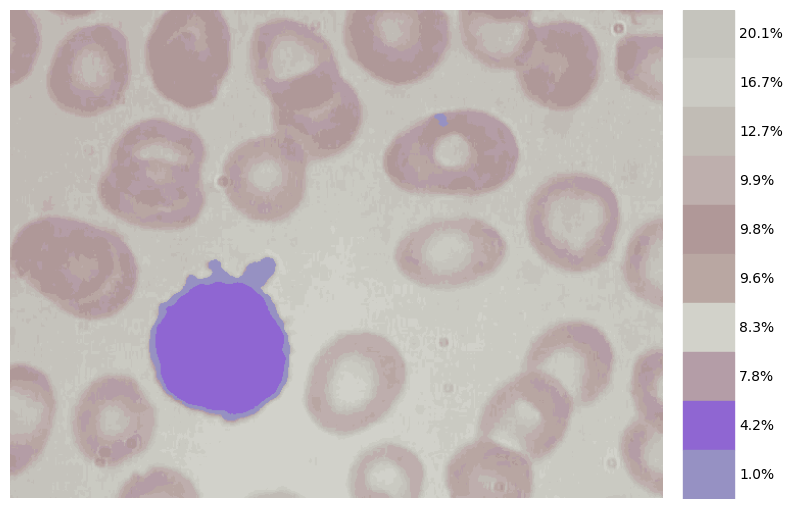

In [ ]:
colors = kmeans_medical.cluster_centers_
labels = kmeans_medical.labels_

# Calculamos proporciones
counts = np.bincount(labels)
proportions = counts / counts.sum()

# Ordenamos de mayor a menor
sorted_idx = np.argsort(proportions)[::-1]
colors_sorted = colors[sorted_idx]
proportions_sorted = proportions[sorted_idx]

# Convertimos colores a float 0-1 para matplotlib
if colors_sorted.max() > 1.0:
    colors_sorted_float = np.clip(colors_sorted / 255.0, 0, 1)
else:
    colors_sorted_float = np.clip(colors_sorted, 0, 1)

# Dimensiones de la imagen
img_height, img_width, _ = segmented_img.shape
n_colors = len(colors_sorted_float)
gap = 20  # separación entre imagen y barra

# Calculamos la altura de cada cuadrado para que la barra tenga la misma altura que la imagen
square_height = img_height / n_colors
square_width = 50  # ancho de los cuadrados

# Creamos la figura
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(segmented_img)
ax.axis('off')

# Posición horizontal inicial de la barra
x_start = img_width + gap

# Dibujamos los cuadrados de colores y escribimos los porcentajes de uso
for i, (color, prop) in enumerate(zip(colors_sorted_float, proportions_sorted)):
    y = i * square_height
    ax.add_patch(plt.Rectangle((x_start, y), square_width, square_height,
                               color=color))
    ax.text(x_start + square_width + 5, y + square_height/2, f"{prop:.1%}",
            va='center', ha='left', fontsize=10, color='black')

# Ajustamos los límites para ver la barra completa
ax.set_xlim(0, img_width + gap + square_width + 50)
ax.set_ylim(img_height, 0)  # invertir eje y
plt.show()

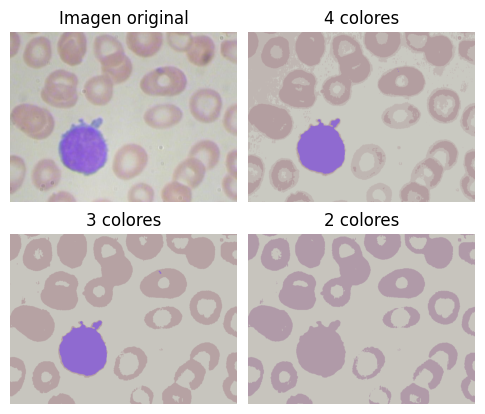

In [ ]:
segmented_imgs = []
n_colors = (4, 3,2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X_medical)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(medical_array.shape))

plt.figure(figsize=(6,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(221)
plt.imshow(medical_array)
plt.title("Imagen original")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(222 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colores".format(n_clusters))
    plt.axis('off')

plt.show()

Vemos que con 2 colores se pierde el morado, nos quedamos con 3 colores.

Vamos a sacar las imágenes de máscaras binarias. Esto es que por cada color se hace una imagen en dos colores, uno para lo está seleccionado de ese color, y otro para lo que no está seleccionado.

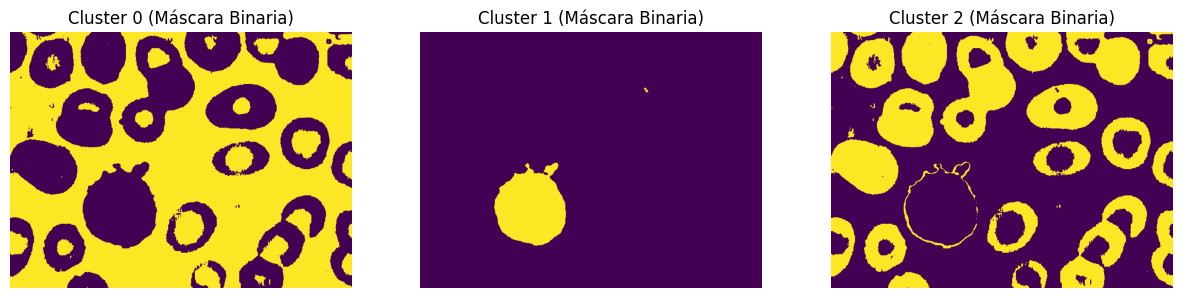

In [ ]:

kmeans = KMeans(n_clusters=3, random_state=42).fit(X_medical)

# Recuperamos las etiquetas y les damos forma de imagen (sin colores, solo 0, 1, 2...)
labels = kmeans.labels_
mascara_img = labels.reshape(medical_array.shape[0], medical_array.shape[1])

# Vamos a pintar cada cluster por separado para ver qué ha encontrado
n_clusters = 3

plt.figure(figsize=(15, 5))

for i in range(n_clusters):
    plt.subplot(1, n_clusters, i+1)
    # Esto muestra en amarillo lo que pertenece al cluster i, y en morado el resto
    plt.imshow(mascara_img == i)
    plt.title(f"Cluster {i} (Máscara Binaria)")
    plt.axis('off')

plt.show()

Esto puede ser muy útil para por ejemplo realizar de forma automática el conteo de glóbulos rojos y glóbulos blancos. Hay enfermedades que dan lugar a un número anómalos de ellos (por ejemplo más globulos blancos de la cuenta). Un ejemplo de esto es la lucemia que da lugar a un número descontrolado de glóbulos blancos, término que se conoce como Leucocitosis. Se podría programar la inteligencia artificial para que cuente los glóbulos blancos gracias a la segmentación por colores y de ahí que pueda detectar anomalías.

## Redes neuronales y clustering

Vamos a cargar el dataset [wines](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) que ya está incorporado en `scikit-learn`, para ellos hay que usar la función `load_wine`. En este dataset tenemos 3 clases de vinos hay que clasificar


Dividimos también el datset en conjunto de prueba y conjunto de entrenamiento

In [ ]:
X_wines, y_wines = load_wine(return_X_y=True,as_frame=True)
X_train, X_test, y_train, y_test = train_test_split(X_wines, y_wines, random_state=42)

In [ ]:
X_wines.shape

(178, 13)

In [ ]:
X_train.shape

(133, 13)

Como vamos a usar redes neuronales, lo ideal es es estandarizar los datos, es decir que cada variable se parezca a una distribución $N(0,1)$.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)

# Transformamos ambos conjuntos con la normalizacion de train
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled=scaler.transform(X_wines)

Vamos a entrenar el modelo, como nuestro dataset es pequeñito vamos a probar con una red simple a ver que resultado obtenemos.

In [ ]:
mlp = MLPClassifier(solver="lbfgs",max_iter=700,random_state=42,hidden_layer_sizes=(5,1,))
mlp.fit(X_train_scaled, y_train)
print("Rendimiento en entenamiento: {:.2f}".format(mlp.score(X_train_scaled, y_train)))
print("Rendimiento en el conjunto de prueba: {:.2f}".format(mlp.score(X_test_scaled, y_test)))
print("Rendimiento en el conjunto total: {:.2f}".format(mlp.score(X_scaled, y_wines)))

Rendimiento en entenamiento: 0.97
Rendimiento en el conjunto de prueba: 0.96
Rendimiento en el conjunto total: 0.97


Vemos que el rendimiento está muy cercano a la perfección, vamos ahora entonces a realizar k-medias para reducir la dimensionalidad de los datos y volver a usar una red neuronal a ver cuánto afecta al rendimiento. Como nuestro dataset tiene 13 variables, tomamos por ejemplo k=9 para que reducir la dimensión de forma perceptible y no dejar una dimensión similar. Las variables ahora serán las distancias a los centroides.

In [ ]:
# Realizamos clustering
kmeans_prep = KMeans(n_clusters=9, random_state=42)
kmeans_prep.fit(X_train_scaled)

# Obtenemos los centroides
centroids_prep = kmeans_prep.cluster_centers_


centroids_prep.shape

(9, 13)

In [ ]:
# Calculamos la distancias de los puntos de X_train a los centroides y estandarizamos.
distance_space_train = pairwise_distances(X_train_scaled, centroids_prep)

scaler=StandardScaler()
scaler.fit(distance_space_train)
distance_space_train_scaled=scaler.transform(distance_space_train)



distance_space_train_scaled.shape

(133, 9)

In [ ]:
# Hacemos lo mismo con el conjunto de test
distance_space_test = pairwise_distances(X_test_scaled, centroids_prep)

distance_space_test_scaled=scaler.transform(distance_space_test)

Con las distancias ya calculadas, volvemos a entrenar una red neuronal y vemos los resultados

In [ ]:
mlp2 = MLPClassifier(solver="lbfgs",max_iter=700,random_state=41,hidden_layer_sizes=(5,1,))
mlp2.fit(distance_space_train_scaled, y_train)
print("Rendimiento en entenamiento: {:.2f}".format(mlp2.score(distance_space_train_scaled, y_train)))
print("Rendimiento en el conjunto de prueba: {:.2f}".format(mlp2.score(distance_space_test_scaled, y_test)))


Rendimiento en entenamiento: 0.91
Rendimiento en el conjunto de prueba: 0.93


El rendimiento es algo peor que el modelo original que teníamos, aunque tambien es un rendimiento más que decente. Igual nos interesa reducir la dimensionalidad a cambio de perder algo de rendimiento. Vemos el balanceo de clases y comprobamos si el modelo ha aprendido algo o simplemente predice la clase mayor en caso de que estén desbalanceadas.

In [ ]:
y_wines.value_counts(normalize=True) * 100

,proportion
target,
1,39.887640
0,33.146067
2,26.966292


Vemos que las clases están casi perfectamente balanceadas por lo que el modelo sí que ha aprendido.

## Aprendizaje semisupervisado

Ahora vamos a tomar el dataset [glass identification](https://archive.ics.uci.edu/dataset/42/glass+identification), en el que dadas ciertas características el objetivo es clasificar el cristal por tipos

In [ ]:
pip install ucimlrepo

Cargamos el fichero

In [ ]:
from ucimlrepo import fetch_ucirepo

glass_identification = fetch_ucirepo(id=42)

X_glass = glass_identification.data.features
y_glass = glass_identification.data.targets

print(glass_identification.variables)

             name     role         type demographic       description  \
0       Id_number       ID      Integer        None              None   
1              RI  Feature   Continuous        None  refractive index   
2              Na  Feature   Continuous        None            Sodium   
3              Mg  Feature   Continuous        None         Magnesium   
4              Al  Feature   Continuous        None          Aluminum   
5              Si  Feature   Continuous        None           Silicon   
6               K  Feature   Continuous        None         Potassium   
7              Ca  Feature   Continuous        None           Calcium   
8              Ba  Feature   Continuous        None            Barium   
9              Fe  Feature   Continuous        None              Iron   
10  Type_of_glass   Target  Categorical        None              None   

                                    units missing_values  
0                                    None             no  
1    

Vemos que tenemos un dataset de 9 variables predictoras continuas

In [ ]:
X_glass

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.00,0.0
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.00,0.0
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.00,0.0
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.00,0.0
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.00,0.0
...,...,...,...,...,...,...,...,...,...
209,1.51623,14.14,0.00,2.88,72.61,0.08,9.18,1.06,0.0
210,1.51685,14.92,0.00,1.99,73.06,0.00,8.40,1.59,0.0
211,1.52065,14.36,0.00,2.02,73.42,0.00,8.44,1.64,0.0
212,1.51651,14.38,0.00,1.94,73.61,0.00,8.48,1.57,0.0


In [ ]:
y_glass.value_counts()

,count
Type_of_glass,
2,76
1,70
7,29
3,17
5,13
6,9


Vemos que las clases están muy desbalanceadas, esto tendremos que tenerlo en cuenta al analizar el rendimiento de nuestro modelo.

In [ ]:
y_glass.value_counts(normalize=True) * 100

,proportion
Type_of_glass,
2,35.514019
1,32.710280
7,13.551402
3,7.943925
5,6.074766
6,4.205607


In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_glass, y_glass, random_state=42)

In [ ]:
X_train2.shape

(160, 9)

Hacemos una regresión logística, con la función `LogisticRegression` de `scikit-learn`.

In [ ]:
log_reg_supervisado = LogisticRegression(solver="lbfgs", max_iter=20000, random_state=42)
log_reg_supervisado.fit(X_train2, y_train2.values.ravel())

log_reg_supervisado_score = log_reg_supervisado.score(X_test2, y_test2)
log_reg_supervisado_score

0.6481481481481481

El rendimiento no es el mejor del mundo, pero al menos sí que ha aprendido y no predice siempre la clase predominante.



¿Qué pasaría si solo tuvieramos 60 datos etiquetados? Veamoslo

In [ ]:
n_labeled = 60 # número de imágenes

log_reg = LogisticRegression(solver="lbfgs", random_state=42,max_iter=10000)
log_reg.fit(X_train2[:n_labeled], y_train2.values.ravel()[:n_labeled])
log_reg.score(X_test2, y_test2)

0.5925925925925926

Vemos que el rendimiento ha caido conforme al modelo originial, ahora vamos a hacer como en la práctica. Vamos a tener 60 ejemplos etiquetados ahora también pero vamos a elegir que ejemplos están etiquetados buscando conjuntos representativos y tomando sus representantes

In [ ]:
k=60
kmeans = KMeans(n_clusters=k, random_state=42)
X_glass_dist = kmeans.fit_transform(X_train2)
representative_glass_idx = np.argmin(X_glass_dist, axis=0)

X_representative_glass = X_train2.iloc[representative_glass_idx]

In [ ]:
y_representative_glass = y_train2.iloc[representative_glass_idx]
y_representative_glass

,Type_of_glass
32,1
173,5
164,5
36,1
205,7
172,5
186,7
112,2
47,1
106,2


Primero haremos un modelo solo con la información que nos otorga el conjunto representativo.

In [ ]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=10000,random_state=42)
log_reg.fit(X_representative_glass, y_representative_glass.values.ravel())
log_reg.score(X_test2, y_test2)

0.6296296296296297

Vemos que el rendimiento es similiar al modelo original que hicimos, pero ahora hemos usado un conjunto de entrenamiento menor al que teníamos originalmente (60 en contraposición a los 160 del conjunto train2)

Ahora vamos a usar solo las etiquetas del conjunto representativo y según el cluster en el que están asignar esa etiqueta

In [ ]:
y_train_propagated = np.empty(len(X_train2), dtype=np.int32)
for i in range(k):   # en cada cluster asignamos la clase de la imagen representativa
    y_train_propagated[kmeans.labels_==i] = y_representative_glass.iloc[i]

In [ ]:
log_reg = LogisticRegression(solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train2, y_train_propagated)
log_reg.score(X_test2, y_test2)

0.6851851851851852

Vemos que el rendimiento a pesar de partir de solo 60 etiquetas es similiar y en este caso incluto mayor que cuando hemos cogido todas las etiquetas conocidas. Debido a la pequeña diferencia de rendimiento no podemos afirmar que realmente sea mejor ya que podría ser una simple casualidad del azar. Pero lo que si podemos afirmar es que el rendimiento es similar. Precisamente este es el potencial del aprendizaje semisupervisado. Eligiendo sabimente qué ejemplos necesitan las etiquetas, se puede obtener un resultado similar poniendo solo unas pocas de etiquetas en lugar de poniendo todas las etiquetas posibles. Esto puede representar una gran ventaja cuando es muy costoso poner las etiquetas.

Vamos a usar ahora `Label Spreading`, que es uno de los métodos de aprendizaje semisupervisado de `scikit-learn`. Se puede encontrar información sobre este método [aquí](https://scikit-learn.org/stable/modules/generated/sklearn.semi_supervised.LabelSpreading.html), al igual que `Label Propagation` también de `scikit-learn` lo que se hace es inferir las etiquetas de los ejemplos a partir de un conjuntos de ejemplos ya etiquetados. La diferencia entre *label propagation* y *label spreading*, es que label spreading elimina más el ruido.

In [ ]:
# Creamos un vector de etiquetas lleno de -1 (que significa "no etiquetado")
y_train_mixed = np.full(len(X_train2), -1)

# Revelamos solo las etiquetas de las 60 muestras representativas
indices_conocidos = representative_glass_idx
y_train_mixed[indices_conocidos] = y_train2.iloc[indices_conocidos].values.ravel()

print(f"Total muestras: {len(X_train2)}")
print(f"Etiquetas conocidas (representativas): {len(indices_conocidos)}")
print(f"Etiquetas ocultas (-1): {np.sum(y_train_mixed == -1)}")

Total muestras: 160
Etiquetas conocidas (representativas): 60
Etiquetas ocultas (-1): 100


Con nuestras etiquetas representativas ya reveladas, hacemos la inferencia de las etiquetas

In [ ]:
ls_model = LabelSpreading(kernel='knn', n_neighbors=7, alpha=0.2)
ls_model.fit(X_train2, y_train_mixed)

y_train_ls_propagated = ls_model.transduction_

Con todas las etiquetas ya puestas, pasamos a hacer una regresión logística

In [ ]:
log_reg_ls = LogisticRegression(solver="lbfgs", max_iter=5000, random_state=42)
log_reg_ls.fit(X_train2, y_train_ls_propagated)
score_log_reg_ls = log_reg_ls.score(X_test2, y_test2)

print(f"Rendimiento LogReg entrenada con etiquetas de Label Spreading: {score_log_reg_ls:.4f}")

Rendimiento LogReg entrenada con etiquetas de Label Spreading: 0.7222


El modelo que hemos obtenido ahora es incluso mejor que el que teníamos al principio, esto se puede deber a que label spreading ayuda a reducir el ruido haciendo que el modelo aprenda mejor. También se puede deber a que como las clases están desbalanceadas, las clases minoritarias son ignoradas en en el supervisado total y al hacer label spreading e inferir las etiquetas, quizás se crean algunos ejemplos artificiales que ayudan a que el modelo les de importancia.

Veamos como se predice por clases con el *classification report* y con la matriz de confusión

===  MODELO SUPERVISADO  ===
              precision    recall  f1-score   support

           1       0.52      0.86      0.65        14
           2       0.69      0.52      0.59        21
           3       0.00      0.00      0.00         4
           5       1.00      0.50      0.67         4
           6       0.67      0.67      0.67         3
           7       0.80      1.00      0.89         8

    accuracy                           0.65        54
   macro avg       0.61      0.59      0.58        54
weighted avg       0.63      0.65      0.62        54



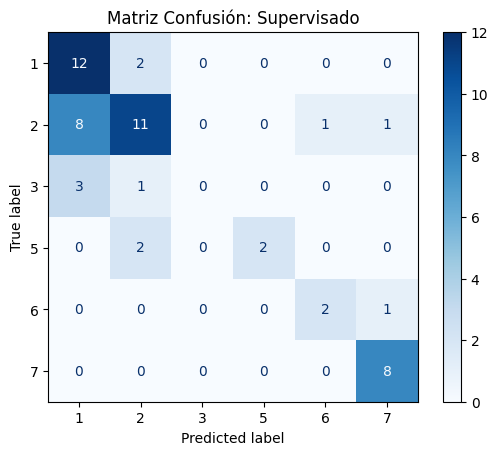



=== MODELO SEMI-SUPERVISADO (Label Spreading + LogReg) ===
              precision    recall  f1-score   support

           1       0.62      0.93      0.74        14
           2       0.78      0.67      0.72        21
           3       0.00      0.00      0.00         4
           5       1.00      0.75      0.86         4
           6       0.50      0.33      0.40         3
           7       0.80      1.00      0.89         8

    accuracy                           0.72        54
   macro avg       0.62      0.61      0.60        54
weighted avg       0.68      0.72      0.69        54



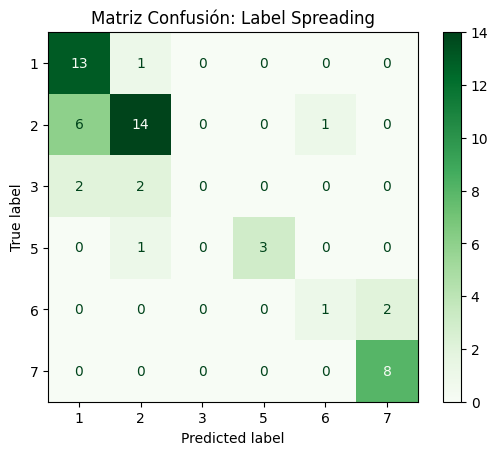

In [ ]:
#Predicciones de los modelos
y_pred_supervisado = log_reg_supervisado.predict(X_test2)
y_pred_semisup = log_reg_ls.predict(X_test2)


print("===  MODELO SUPERVISADO  ===")
print(classification_report(y_test2, y_pred_supervisado, zero_division=0))
disp = ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_supervisado, cmap='Blues')
disp.ax_.set_title("Matriz Confusión: Supervisado")
plt.show()

print("\n" + "="*60 + "\n")

print("=== MODELO SEMI-SUPERVISADO (Label Spreading + LogReg) ===")
print(classification_report(y_test2, y_pred_semisup, zero_division=0))
disp = ConfusionMatrixDisplay.from_predictions(y_test2, y_pred_semisup, cmap='Greens')
disp.ax_.set_title("Matriz Confusión: Label Spreading")
plt.show()

Vemos que con label spreading el modelo parece haber aprendido mejor a diferenciar los cristales de tipo 1,2 y 5 y ha empeorado con los de tipo 6. Seguramente esto se debe a que se ha eliminado el ruido al hacer Label Spreading. Igualmente al tener un dataset pequeño, no podemos hacer comprobaciones mayores ya que por ejemplo de la etiqueta 3 solo tenemos 4 ejemplos en el dataset de prueba, igual con la etiqueta 5 y de la etiqueta 6 solo 3 ejemplos.